---
title: "Dimensionality Reduction"
format:
  html:
      embed-resources: true
      code-fold: true
---

## Objectives

In this section, we will be using dimensionality reduction techniques to gain insights on public transit data for major US cities. The dataset for this comes from the American Public Transit Association Ridership Report, which contains details about public transit ridership from 2022. [^1]

While this dataset does contain some information on the volume of ridership, unsupervised learning is generally done without a target variable or known relationships within the data. Thus, the features of this dataset are city population, city area (square miles), average cost per trip (dollars), average fare per trip (dollars), and average miles per trip, where the observation unit for each record is an individual city. In practice, all of these features could be factors in understanding the health of a public transit system, as they all either provide information on the city itself, the conditions for the riders, or the cost for the city. Thus, the objective of dimensionality reduction is to discover things about these features and how they interact with one another.

To do dimensionality reduction, there are two common methods: Principal Component Analysis (PCA) and T-distributed Stochastic Neighbor Embedding (TSNE). Both will be applied to this dataset. We will be using the following Python libraries to accomplish these:

- `numpy` for obtaining eigenvalues and eigenvectors
- `sklearn` for implementing PCA and TSNE
- `matplotlib` and `seaborn` for visualizations

## Implementation

### Dimensionality Reduction with PCA

*Note: Some of this code is repurposed from DSAN-5000 Week 10 slides.*

In [2]:
import pandas as pd
cities = pd.read_csv('../data/cleaned_data/apta_cities_cleaned.csv')
cities = cities.drop(columns=['Unnamed: 0'])
cities.head()

,City,Population,Area,Cost_per_trip,Fare_per_trip,Miles_per_trip,Total_trips,Trips_per_capita
0,"Seattle--Tacoma, WA",3544011,982.52,13.906032,1.570667,5.786344,130093841,36.708080
1,"Spokane, WA",447279,171.67,13.433827,0.988308,4.772569,6995911,15.641045
2,"Yakima, WA",133145,55.77,19.720093,1.112531,5.179168,513484,3.856577
3,"Eugene, OR",270179,73.49,10.851494,2.753356,3.684118,5296214,19.602612
4,"Portland, OR--WA",2104238,519.30,10.804361,1.025659,4.011388,56312874,26.761647


A crucial step for PCA is first obtaining eigenvalues and eigenvectors to figure out the properties of the feature matrix. This process is printed below.

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

X = cities.drop(columns=['City']).to_numpy()

print('NUMERIC MEAN:\n',np.mean(X,axis=0))
print("X SHAPE",X.shape)
print("NUMERIC COV:")
print(np.cov(X.T))

from numpy import linalg as LA
w, v1 = LA.eig(np.cov(X.T))
print("\nCOV EIGENVALUES:",w)
print("COV EIGENVECTORS (across rows):")
print(v1.T)

NUMERIC MEAN:
 [7.63817374e+05 2.54954371e+02 1.62164796e+01 1.69764181e+00
 6.02033451e+00 2.03019959e+07 9.62142228e+00]
X SHAPE (286, 7)
NUMERIC COV:
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
[[ 3.00348049e+12  6.21976504e+08 -2.68509287e+06 -2.80714130e+05
  -3.74964286e+05  2.24741175e+14  1.29984354e+07]
 [ 6.21976504e+08  1.60662563e+05 -7.09356971e+02 -8.34065149e+01
  -1.18548286e+02  3.87177727e+10  2.29845351e+03]
 [-2.68509287e+06 -7.09356971e+02  1.12521769e+02  1.14344019e+01
   1.54309551e+01 -1.51824020e+08 -4.69434589e+01]
 [-2.80714130e+05 -8.34065149e+01  1.14344019e+01  1.07182685e+01
   6.17463373e+00 -4.36561531e+06 -2.83807355e+00]
 [-3.74964286e+05 -1.18548286e+02  1.54309551e+01  6.17463373e+00
   2.61947556e+01 -1.78488703e+07 -5.91059175e+00]
 [ 2.2474117

Upon obtaining the properties of our dataset, we can now use `sklearn` to implement PCA. The steps for this are as follows:

- Normalize the feature matrix using the `StandardScalar()` function
- Sort the eigenvectors in order to prioritize principal components
- Find the cumulative sum of the principal components to find the proportion of the variance that can be explained by each number of features
- Plot this cumulative distribution

*Note: Some of this code is repurposed from https://www.geeksforgeeks.org/reduce-data-dimentionality-using-pca-python/* [^2]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/z5/l6g0391s0qg3vsbnvl7y81n80000gn/T/ipykernel_81423/3215643524.py:17: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(1, 5, 1)


(1.0, 5.0)

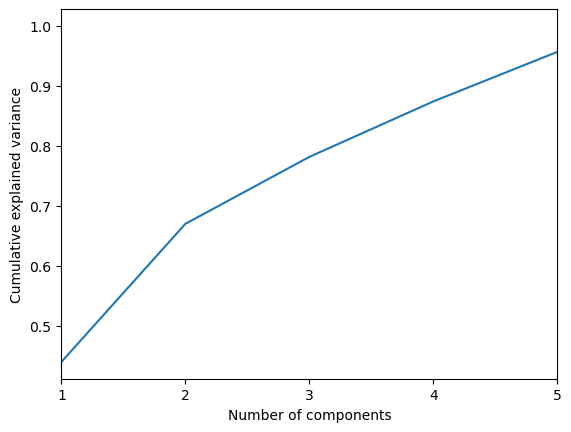

In [4]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
cov = (X.T @ X) / (X.shape[0] - 1)
w, v1 = np.linalg.eig(cov)

idx = np.argsort(w, axis=0)[::-1]
sorted_eig_vectors = v1[:, idx]

cumsum = np.cumsum(w[idx]) / np.sum(w[idx])
xint = range(1, len(cumsum) + 1)
plt.plot(xint, cumsum)

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.xticks(xint)
plt.xlim(1, 5, 1)

From the plot above, we can see that greater than 95% of the cumulative explained variance is covered by 4 components. Therefore, it is reasonable to select that as the number of principal components. A good way to check the efficacy of this is to plot the covariance using `seaborn` from before and after PCA. Below is the covariance matrix of the feature dataset, which clearly shows a significant amount of covariance between a few of the variables.

<Axes: >

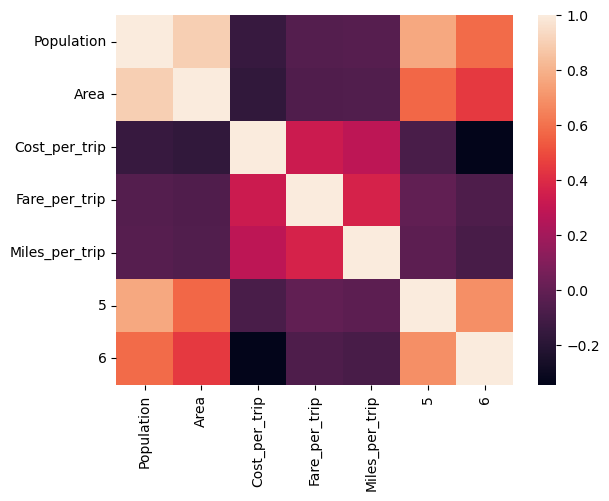

In [5]:
import seaborn as sns
X_df = pd.DataFrame(X).rename(columns={0: 'Population', 1: 'Area', 2: 'Cost_per_trip', 3: 'Fare_per_trip', 4: 'Miles_per_trip'})
sns.heatmap(X_df.corr())

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(X)
data_pca = pca.transform(X)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4'])
data_pca.head()

,PC1,PC2,PC3,PC4
0,3.033796,0.350153,0.122935,0.019467
1,0.070137,-0.474524,0.321328,-0.191796
2,-0.723213,-0.152967,-0.292844,-0.111154
3,0.051012,-0.449029,0.788093,-0.746024
4,1.584307,-0.407123,0.325299,-0.194906


After applying PCA, below is another heatmap showing the covariance between principal components, which greatly highlights the usefulness of this process. There is essentially no covariance between principal components, indicating that the 4 component selection was effective in summarizing data.

<Axes: >

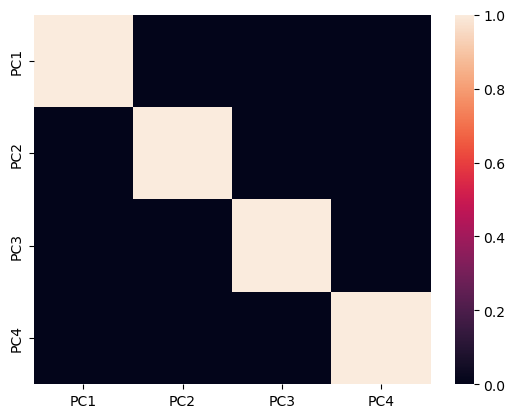

In [7]:
sns.heatmap(data_pca.corr())

Finally, below is a plot to visualize the data after selecting principal components.

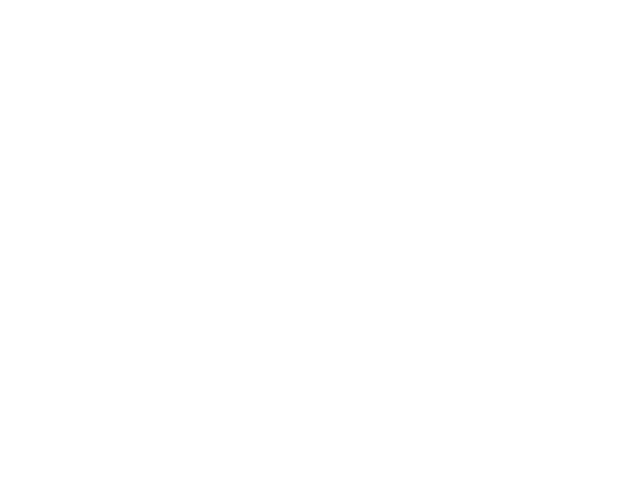

In [16]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data_pca['PC2'],data_pca['PC3'],data_pca['PC4'], c=data_pca['PC1'])
ax.set_title("3D Plot of Principal Components")
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
ax.set_zlabel('PC4')
plt.show()

### Dimensionality Reduction with TSNE

For implementing TSNE, we will once again be using `sklearn`. The `TSNE()` function unfortunately limits to three components, so this will mainly be used for parameter tuning to analyze different perplexities and how they affect our visualizations. The results of a couple of these implementations are below:

RESULTS
shape :  (286, 3)
First few points : 
 [[  1.4826158   8.286032    4.584907 ]
 [ 11.727755   -5.2766175 -22.360485 ]
 [  5.0308733   5.835106  -26.438314 ]
 [  3.2732215  -2.770161    4.2295136]]


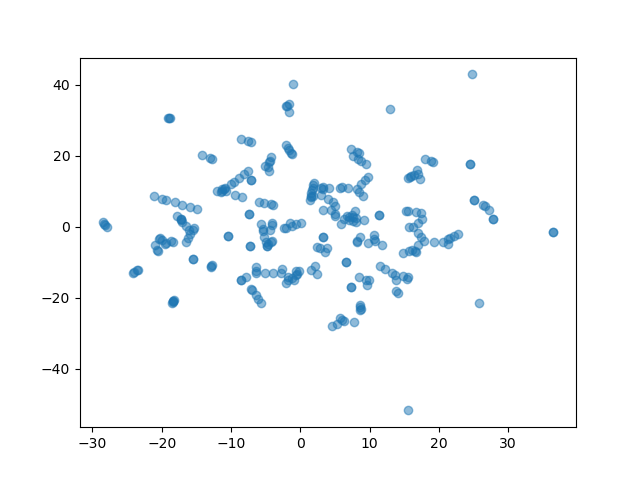

In [17]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=1).fit_transform(X)

# EXPLORE RESULTS
print("RESULTS") 
print("shape : ",X_embedded.shape)
print("First few points : \n",X_embedded[0:4,:])

# PLOT 
plt.scatter(X_embedded[:,0],X_embedded[:,1], alpha=0.5)
plt.show()

In [10]:
X_embedded = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=10).fit_transform(X)

# EXPLORE RESULTS
print("RESULTS") 
print("shape : ",X_embedded.shape)
print("First few points : \n",X_embedded[0:4,:])

RESULTS
shape :  (286, 3)
First few points : 
 [[ 7.439387    7.215633    3.3639798 ]
 [ 0.01349061  5.4039626  -0.5400352 ]
 [-2.5031161  -4.7561264  -3.151865  ]
 [ 0.34158447  7.827049   -3.8418515 ]]


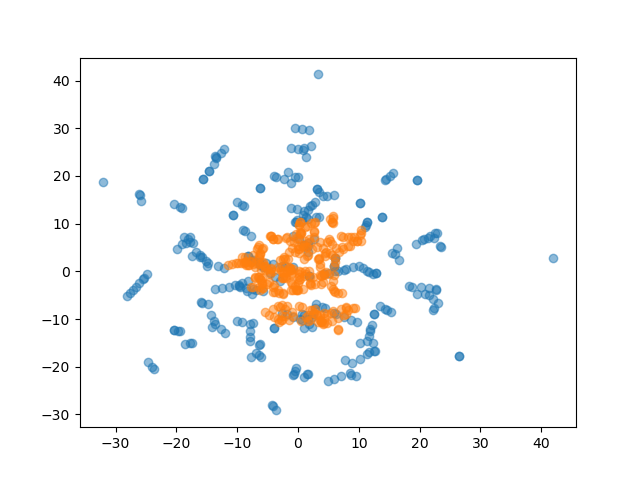

In [11]:
# PLOT 
plt.scatter(X_embedded[:,0],X_embedded[:,1], alpha=0.5)
plt.show()

## Evaluation

Ultimately, for this application, PCA proved to be a more useful process for understanding relationships within the feature matrix of our data. In general, PCA is ideal for preserving variance in the data, while TSNE preserves relationships more effectively. The crucial difference between the two is that PCA is a linear technique while TSNE is non-linear. For a dataset like this one, where ordering of data points is not a factor, the features were separable from one another, and the initial dimensionality is quite low, PCA is likely to be more effective.

[^1]: “Raw monthly ridership (no adjustments or estimates),” Raw Monthly Ridership (No Adjustments or Estimates) | FTA, https://www.transit.dot.gov/ntd/data-product/monthly-module-raw-data-release (accessed Nov. 14, 2023).

[^2]: “Reduce data dimensionality using PCA - Python,” GeeksforGeeks, https://www.geeksforgeeks.org/reduce-data-dimentionality-using-pca-python/ (accessed Nov. 14, 2023). 